# The 3 E's 

## Using world development indicators to predict PISA scores

Have you ever been curious on how the development indicators of a country may be linked in some way?  What if there were a way to predict the performance of educational scores by looking at the development indicators of a country?  In my project, I will attempt just that.  

To hone in on data that tells a story, I have chose to look at 3 specific indicator groupings, affectionately titled, "The 3 E's".  The 3 E's and some of the indicator codes you will see under each one are as follows:

* Education - Enrollment rates, ratio of teachers to students,vocational versus primary school enrollments
* Economy - Gross domestic productic (GDP), inflation, 
* Employment - Wage & salaried workers, unemployment rates based on different criteria

The 3 E's contain a variety of indicators.  In my project, you will see indicators 

(talk about what is under each indicator like enrollment, vocational versus primary school, employment rates, etc - what makes up the 3 E's)

To do this, I have brought in data from the following sources:
* World Development Indicator Dataset from Kaggle:  https://www.kaggle.com/worldbank/world-development-indicators

The World Development Indicator Dataset includes over a thousand annual indicators for roughly 247 countries.  The dataset has information for 55 years (1960 to 2015).

* PISA data:  https://pisadataexplorer.oecd.org/ide/idepisa/

The PISA data website allows us to select from 100s of countries.  It measures the performance of 15 year old students in the subjects of math, science, and reading.  The data used in my project brings in the PISA scores from the following years:  
* 2000
* 2003
* 2006
* 2009
* 2012
* 2015

What are PISA Scores?

The Programme for International Student Assessment, better known as PISA, is a worldwide study with the intent to evaluate education systems.  The study is done by the Organization for Economic Cooperation and Development (OECD) in member and non-member nations.   

My notebook will guide you through data cleaning, exploration, modeling, and final summary.  Graphs such as correlation heatmaps will show how educational scores and indicator scores relate to each other.  Models will serve as predictors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import random
import re
import textwrap
import warnings
warnings.filterwarnings('ignore')
import csv
import seaborn as sbn
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn import svm
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import csv
import seaborn as sbn
%matplotlib inline
from sklearn import linear_model
import math
pd.options.display.float_format = '{:.3f}'.format
from sklearn import preprocessing
sns.set_style('white')
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
import statsmodels.api as sm
from sklearn import tree 

In [2]:
Country = pd.read_csv('Country.csv')
CountryNotes = pd.read_csv('CountryNotes.csv')
Indicators = pd.read_csv('Indicators.csv',header = 0,skiprows = range(1,3171013))
Series = pd.read_csv('Series.csv')
SeriesNotes = pd.read_csv('SeriesNotes.csv')
PISA = pd.read_csv('PISA_Combine3.csv')
Region = pd.read_csv('all country.csv')

# Data Cleaning

Let's work on cleaning up our data before we start to model. The 'Indicator' dataset is quite large as it contains indicators for multiple countriest starting in the 1960's. We want to look at the indicators starting in the year 2000 and after. You might have noticed that we added some more code after we imported our csv with the pd.read_csv() funtion. This allows us to keep the column heads (header = 0), and import our 'Indicator' dataset starting at the row dictated by the code. Our imported dataset now starts at the first instance for the year 2000.

In [3]:
Indicators.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Arab World,ARB,Access to electricity (% of population),EG.ELC.ACCS.ZS,2000,79.537
1,Arab World,ARB,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,2000,65.869
2,Arab World,ARB,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,2000,91.655
3,Arab World,ARB,Access to non-solid fuel (% of population),EG.NSF.ACCS.ZS,2000,81.565
4,Arab World,ARB,"Adjusted net enrolment rate, primary, both sex...",SE.PRM.TENR,2000,78.489


I have imported a variety of datasets. In order to be successful with our modeling, I will need to bring in information from the different datasets and merge them into 1 to work off of.

Let's rename the column name on the 'Region' csv to match the 'Country' csv so that we can use that as the unique indicator to merge our 2 datasets on.

In [4]:
region = Region.rename(columns={'alpha-3': 'CountryCode'})

In [5]:
region.columns

Index(['name', 'alpha-2', 'CountryCode', 'country-code', 'iso_3166-2',
       'region', 'sub-region', 'intermediate-region', 'region-code',
       'sub-region-code', 'intermediate-region-code'],
      dtype='object')

We will first merge the 'Country' csv with the updated 'region' dataframe.  This will allow us to bring in the region and sub-region information.

In [6]:
countrydf = pd.read_csv('Country.csv')
region_update = region

country_region = countrydf.merge(region, on='CountryCode')

Let's merge our new 'country_region' dataframe with the PISA information now.

In [7]:
country_main = country_region
pisadf = pd.read_csv("PISA_Combine3.csv")

combine = country_main.merge(pisadf, on="CountryCode")

As a final merge, we will now combine our updated 'combine' dataframe with the indicator data so that we can work through some models.

In [8]:
indicatordf = pd.read_csv("Indicators.csv")
main = combine.merge(indicatordf, on=['Year','CountryCode'])

In [9]:
main.columns

Index(['CountryCode', 'ShortName', 'TableName', 'LongName', 'Alpha2Code',
       'CurrencyUnit', 'SpecialNotes', 'Region', 'IncomeGroup', 'Wb2Code',
       'NationalAccountsBaseYear', 'NationalAccountsReferenceYear',
       'SnaPriceValuation', 'LendingCategory', 'OtherGroups',
       'SystemOfNationalAccounts', 'AlternativeConversionFactor',
       'PppSurveyYear', 'BalanceOfPaymentsManualInUse',
       'ExternalDebtReportingStatus', 'SystemOfTrade',
       'GovernmentAccountingConcept', 'ImfDataDisseminationStandard',
       'LatestPopulationCensus', 'LatestHouseholdSurvey',
       'SourceOfMostRecentIncomeAndExpenditureData',
       'VitalRegistrationComplete', 'LatestAgriculturalCensus',
       'LatestIndustrialData', 'LatestTradeData', 'LatestWaterWithdrawalData',
       'name', 'alpha-2', 'country-code', 'iso_3166-2', 'region', 'sub-region',
       'intermediate-region', 'region-code', 'sub-region-code',
       'intermediate-region-code', 'Year', 'Jurisdiction', 'Average',
      

For project purposes, I will create a copy of my fully merged dataset.  This is being done in the event that I need to refer back to the original version.

In [10]:
project = main.copy()

There are a lot of columns present that we don't need for our analysis.  Let's drop them.

In [11]:
project.drop(["ShortName","LongName","Alpha2Code","Wb2Code","SnaPriceValuation","SpecialNotes","Region","intermediate-region-code","sub-region-code","VitalRegistrationComplete","LatestAgriculturalCensus",
                    "LatestIndustrialData","LatestTradeData","LatestWaterWithdrawalData","SourceOfMostRecentIncomeAndExpenditureData",
                    "LatestHouseholdSurvey","LatestPopulationCensus","ImfDataDisseminationStandard","GovernmentAccountingConcept","intermediate-region",
                    "NationalAccountsBaseYear", "NationalAccountsReferenceYear", "LendingCategory", "OtherGroups", "SystemOfNationalAccounts",
                    "AlternativeConversionFactor", "PppSurveyYear", "BalanceOfPaymentsManualInUse", "ExternalDebtReportingStatus",
                    "region-code", "TableName","alpha-2","iso_3166-2","Jurisdiction" ], axis = 1, inplace = True) 

What do our columns look like now?

In [12]:
project.columns

Index(['CountryCode', 'CurrencyUnit', 'IncomeGroup', 'SystemOfTrade', 'name',
       'country-code', 'region', 'sub-region', 'Year', 'Average',
       'Standard Error', 'Area', 'CountryName', 'IndicatorName',
       'IndicatorCode', 'Value'],
      dtype='object')

In [13]:
project.rename(columns = {'CountryCode':'Country Code Alpha', 'CurrencyUnit':'Currency Unit', 
                          'IncomeGroup':'Income Group', 'SystemofTrade':'System of Trade','name':'Country',
                          'country-code':'Country Code Numeric','region':'Region','sub-region':'Sub Region', 
                          'Average':'PISA Score Average','Standard Error':'PISA Score Standard Error','Area':'Subject',
                          'IndicatorName':'Indicator Name','Indicator Code':'IndicatorCode','Value':'IndicatorCodeValue'}, inplace = True)

In [14]:
project.head(1)

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue
0,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2015,nan,nan,Math,Albania,Bank capital to assets ratio (%),FB.BNK.CAPA.ZS,9.700


Let's get an idea of how much of the data is null.  This will allow us to scrub our dataset further.  We can do this a couple of ways.

First Option:  What is the percentage of null for each column in my dataframe?

In [15]:
project.isnull().sum()/len(project)*100

Country Code Alpha           0.000
Currency Unit                0.000
Income Group                 0.000
SystemOfTrade                0.000
Country                      0.000
Country Code Numeric         0.000
Region                       0.000
Sub Region                   0.000
Year                         0.000
PISA Score Average          38.899
PISA Score Standard Error   38.899
Subject                      0.000
CountryName                  0.000
Indicator Name               0.000
IndicatorCode                0.000
IndicatorCodeValue           0.000
dtype: float64

Second option:  What are the counts of the nulls for each column in my dataframe?

In [16]:
project.isnull().sum(axis=0)

Country Code Alpha                0
Currency Unit                     0
Income Group                      0
SystemOfTrade                     0
Country                           0
Country Code Numeric              0
Region                            0
Sub Region                        0
Year                              0
PISA Score Average           297153
PISA Score Standard Error    297153
Subject                           0
CountryName                       0
Indicator Name                    0
IndicatorCode                     0
IndicatorCodeValue                0
dtype: int64

We can see that the columns of 'PISA Score Average' and 'PISA Standard Error' are the only 2 that contain null values.  We are looking at PISA scores for countries for 6 different years.  This is telling us that not all countries have scores for all of the years.  We need to keep this in mind as we work through the data for modeling.

In [17]:
project.Year.unique()

array([2015, 2006, 2003, 2000, 2012, 2009])

In [18]:
project.Subject.unique()

array(['Math', 'Reading', 'Science'], dtype=object)

The data contains multiple indicators that are broken out by country as well as year.  Since we are focusing on the 3 E's, let's create a picklist so that we are able to filter out the codes that we need.

In [19]:
indicators = Indicators['IndicatorName'].unique().tolist()
indicators.sort()

In [20]:
indicators_list = Indicators[['IndicatorName','IndicatorCode']].drop_duplicates().values

In [21]:
indicators_list

array([['Access to electricity (% of population)', 'EG.ELC.ACCS.ZS'],
       ['Access to electricity, rural (% of rural population)',
        'EG.ELC.ACCS.RU.ZS'],
       ['Access to electricity, urban (% of urban population)',
        'EG.ELC.ACCS.UR.ZS'],
       ...,
       ['Fish species, threatened', 'EN.FSH.THRD.NO'],
       ['Mammal species, threatened', 'EN.MAM.THRD.NO'],
       ['Plant species (higher), threatened', 'EN.HPT.THRD.NO']],
      dtype=object)

In [22]:
new_indicators =[]
indicators_code =[]

for ind in indicators_list:
    indicator = ind[0]
    code = ind[1].strip()
    if code not in indicators_code:
        #Delete ,() from indicators and convert all characters to lower case
        modified_indicator = re.sub('[,()]',"",indicator).lower()
        #Replace - with "to"
        modified_indicator = re.sub('-'," to ",modified_indicator).lower()
        new_indicators.append([modified_indicator,code])
        indicators_code.append(code)

In [23]:
Indicators = pd.DataFrame(new_indicators, columns=['IndicatorName','IndicatorCode'])
Indicators = Indicators.drop_duplicates()
print(Indicators.shape)

(1344, 2)


In [24]:
key_word_dict = {}

key_word_dict['Economy'] = ['gdp']
key_word_dict['Education'] = ['literacy','enrolment']
key_word_dict['Employment'] =['employed','employment','umemployed','unemployment']

Using the key word dictionary we created above, let's create a way to see all the different features under a keyword.

In [25]:
def pick_indicator(feature):
   
    indicator_name = []
    
    for indicator_ele in Indicators.values:
        
        if feature not in key_word_dict.keys():
            print("Choose the right feature!")
            break
        
        for word in key_word_dict[feature]:
            
            word_list = indicator_ele[0].split() # it would split from ','
            
            if word in word_list or word+'s' in word_list:
                
                print(indicator_ele[1])
                
                indicator_name.append(indicator_ele[1])
                
                break
                
    return indicator_name

We now have the ability to use the pick_indicator function in order to see the list of indicators for a chosen group.  Let's set a line of code for each of the 3 E's.

In [26]:
economy = pick_indicator('Economy')

NV.AGR.TOTL.ZS
EN.ATM.CO2E.KD.GD
EN.ATM.CO2E.PP.GD.KD
EN.ATM.CO2E.PP.GD
NY.GDP.COAL.RT.ZS
EG.EGY.PRIM.PP.KD
EG.USE.COMM.GD.PP.KD
NE.EXP.GNFS.ZS
NE.RSB.GNFS.ZS
BX.KLT.DINV.WD.GD.ZS
NY.GDP.FRST.RT.ZS
NY.GDP.MKTP.KD
NY.GDP.MKTP.CD
NY.GDP.MKTP.KD.ZG
NY.GDP.PCAP.KD
NY.GDP.PCAP.CD
NY.GDP.PCAP.KD.ZG
NY.GDP.PCAP.PP.KD
NY.GDP.PCAP.PP.CD
SL.GDP.PCAP.EM.KD
EG.GDP.PUSE.KO.PP.KD
EG.GDP.PUSE.KO.PP
NY.GDP.MKTP.PP.KD
NY.GDP.MKTP.PP.CD
NE.CON.GOVT.ZS
NE.GDI.TOTL.ZS
NY.GDS.TOTL.ZS
NE.GDI.FTOT.ZS
SH.XPD.PRIV.ZS
SH.XPD.PUBL.ZS
SH.XPD.TOTL.ZS
NE.CON.PETC.ZS
NE.IMP.GNFS.ZS
NV.IND.TOTL.ZS
NY.GDP.DEFL.KD.ZG
NV.IND.MANF.ZS
TG.VAL.TOTL.GD.ZS
MS.MIL.XPND.GD.ZS
NY.GDP.MINR.RT.ZS
NY.GDP.NGAS.RT.ZS
NY.GDP.PETR.RT.ZS
NV.SRV.TETC.ZS
NY.GDP.TOTL.RT.ZS
NE.TRD.GNFS.ZS
NY.GNS.ICTR.ZS
BX.TRF.PWKR.DT.GD.ZS
CM.MKT.LCAP.GD.ZS
GC.FIN.DOMS.GD.ZS
GC.FIN.FRGN.GD.ZS
GB.XPD.RSDV.GD.ZS
CM.MKT.TRAD.GD.ZS
GC.BAL.CASH.GD.ZS
GC.DOD.TOTL.GD.ZS
GC.XPN.TOTL.GD.ZS
GC.REV.XGRT.GD.ZS
GC.TAX.TOTL.GD.ZS
NE.GDI.FPRV.ZS
NY.GDP.DISC.KN
NY.GDP.DIS

In [27]:
education = pick_indicator('Education')

SE.PRM.TENR
SE.PRM.TENR.FE
SE.PRM.TENR.MA
SE.ADT.LITR.ZS
SE.ADT.LITR.FE.ZS
SE.ADT.LITR.MA.ZS
SE.PRM.ENRL
SE.SEC.ENRL
SE.SEC.ENRL.GC
SE.SEC.ENRL.VO
SE.PRE.ENRR
SE.PRE.ENRR.FE
SE.PRE.ENRR.MA
SE.ENR.PRSC.FM.ZS
SE.PRM.ENRR
SE.PRM.ENRR.FE
SE.ENR.PRIM.FM.ZS
SE.PRM.ENRR.MA
SE.SEC.ENRR
SE.SEC.ENRR.FE
SE.ENR.SECO.FM.ZS
SE.SEC.ENRR.MA
SE.TER.ENRR
SE.TER.ENRR.FE
SE.ENR.TERT.FM.ZS
SE.TER.ENRR.MA
SE.PRM.NENR
SE.PRM.NENR.FE
SE.PRM.NENR.MA
SE.SEC.NENR
SE.SEC.NENR.FE
SE.SEC.NENR.MA
SE.PRM.PRIV.ZS
SE.SEC.PRIV.ZS
SE.ADT.1524.LT.ZS
SE.ADT.1524.LT.FE.ZS
SE.ADT.1524.LT.FM.ZS
SE.ADT.1524.LT.MA.ZS


In [28]:
employment = pick_indicator('Employment')

SL.EMP.TOTL.SP.FE.ZS
SL.EMP.TOTL.SP.MA.ZS
SL.EMP.TOTL.SP.ZS
SL.EMP.1524.SP.FE.ZS
SL.EMP.1524.SP.MA.ZS
SL.EMP.1524.SP.ZS
SL.GDP.PCAP.EM.KD
SL.UEM.TOTL.FE.ZS
SL.UEM.TOTL.FE.NE.ZS
SL.UEM.TOTL.MA.ZS
SL.UEM.TOTL.MA.NE.ZS
SL.UEM.TOTL.ZS
SL.UEM.TOTL.NE.ZS
SL.UEM.1524.FE.ZS
SL.UEM.1524.MA.ZS
SL.UEM.1524.ZS
SL.FAM.WORK.FE.ZS
SL.FAM.WORK.MA.ZS
SL.FAM.WORK.ZS
SL.EMP.MPYR.FE.ZS
SL.EMP.MPYR.MA.ZS
SL.EMP.MPYR.ZS
SL.AGR.EMPL.ZS
SL.AGR.EMPL.FE.ZS
SL.AGR.EMPL.MA.ZS
SL.IND.EMPL.ZS
SL.IND.EMPL.FE.ZS
SL.IND.EMPL.MA.ZS
SL.SRV.EMPL.ZS
SL.SRV.EMPL.FE.ZS
SL.SRV.EMPL.MA.ZS
SL.EMP.TOTL.SP.FE.NE.ZS
SL.EMP.TOTL.SP.MA.NE.ZS
SL.EMP.TOTL.SP.NE.ZS
SL.EMP.1524.SP.FE.NE.ZS
SL.EMP.1524.SP.MA.NE.ZS
SL.EMP.1524.SP.NE.ZS
SL.UEM.LTRM.ZS
SL.UEM.LTRM.FE.ZS
SL.UEM.LTRM.MA.ZS
SL.TLF.PART.FE.ZS
SL.TLF.PART.TL.FE.ZS
SL.TLF.PART.MA.ZS
SL.TLF.PART.ZS
SL.EMP.SELF.FE.ZS
SL.EMP.SELF.MA.ZS
SL.EMP.SELF.ZS
SL.EMP.INSV.FE.ZS
SL.UEM.PRIM.ZS
SL.UEM.PRIM.FE.ZS
SL.UEM.PRIM.MA.ZS
SL.UEM.SECO.ZS
SL.UEM.SECO.FE.ZS
SL.UEM.SECO.MA.ZS
SL.UEM.TERT.Z

The 3 dataframes for each PISA subject I want to show have been created.  However, before we go down the path of creating the models, let's do some work to see if our data is highly correlated.  If they are highly correlated, our models will not really show a lot of difference and will be irrelevant.

In [29]:
PISA.groupby(['Jurisdiction','Year','Area']).Average.mean().unstack().corr()

Area,Math,Reading,Science
Area,,,
Math,1.000,0.955,0.977
Reading,0.955,1.000,0.966
Science,0.977,0.966,1.000


The 3 areas are highly correlated with each other.  Since they are all highly correlated with each other, will just focus on 1 subject.  For my supervised learning capstone, I will be focusing on the 3 E's and how they can predict the Math PISA score and performance.

Let' start by creating new data frames that group the applicable indicator codes with the 'E' it is related to.

In [30]:
education_data = project[project.IndicatorCode.isin(education)]
employment_data = project[project.IndicatorCode.isin(employment)]
economy_data = project[project.IndicatorCode.isin(economy)]

In [31]:
economy_list = []

for e in economy_data.IndicatorCode.unique():
    last_val = e.split('.')
    if ('KN' not in last_val)and('CN' not in last_val)and('KD' not in last_val)and('GD' not in last_val)and('ZG' not in last_val)and('RF' not in last_val)and('PPP' not in last_val)and('ZS' not in last_val)and('1524' not in last_val)and('PP' not in last_val)and('NE' not in last_val):
        economy_list.append(e)

In [32]:
education_list = []

for e in education_data.IndicatorCode.unique():
    last_val = e.split('.')
    if ('FE' not in last_val)and('MA' not in last_val)and('GC' not in last_val)and('ENRR' not in last_val)and('1524' not in last_val)and('FM' not in last_val)and('NE' not in last_val):
        economy_list.append(e)

In [33]:
employment_list = []

for e in employment_data.IndicatorCode.unique():
    last_val = e.split('.')
    if ('FE' not in last_val)and('MA' not in last_val)and('0714' not in last_val)and('1524' not in last_val)and('adq_pop_tot' not in last_val)and('NE' not in last_val):
        economy_list.append(e)

In [34]:
grouped_multiple = education_data.groupby(['Indicator Name', 'IndicatorCode']).agg({'IndicatorCodeValue': ['mean']})
grouped_multiple

,,IndicatorCodeValue
,,mean
Indicator Name,IndicatorCode,
"Adjusted net enrolment rate, primary, both sexes (%)",SE.PRM.TENR,97.173
"Adjusted net enrolment rate, primary, female (%)",SE.PRM.TENR.FE,96.830
"Adjusted net enrolment rate, primary, male (%)",SE.PRM.TENR.MA,96.929
"Adult literacy rate, population 15+ years, both sexes (%)",SE.ADT.LITR.ZS,93.331
"Adult literacy rate, population 15+ years, female (%)",SE.ADT.LITR.FE.ZS,91.546
"Adult literacy rate, population 15+ years, male (%)",SE.ADT.LITR.MA.ZS,95.105
"Enrolment in primary education, both sexes (number)",SE.PRM.ENRL,2884162.148
"Enrolment in secondary education, both sexes (number)",SE.SEC.ENRL,2846447.895


In [35]:
education_data.head(2)

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue
430,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in primary education, both sexes (nu...",SE.PRM.ENRL,222402.000
431,ALB,Albanian lek,Upper middle income,General trade system,Albania,8,Europe,Southern Europe,2006,nan,nan,Math,Albania,"Enrolment in secondary education, both sexes (...",SE.SEC.ENRL,408980.000


We have our new data frames that only contain indicator codes for our 3 'E's.  For our models, we want to look at how the 3 E's can help us predict the PISA scores for Math.  We wil need to combine the 3 dataframes we just created for each of our E's.

In [36]:
e_model = pd.concat([education_data, employment_data, economy_data])
e_model.tail()

,Country Code Alpha,Currency Unit,Income Group,SystemOfTrade,Country,Country Code Numeric,Region,Sub Region,Year,PISA Score Average,PISA Score Standard Error,Subject,CountryName,Indicator Name,IndicatorCode,IndicatorCodeValue
763769,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Price level ratio of PPP conversion factor (GD...,PA.NUS.PPPC.RF,0.351
763827,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,"Services, etc., value added (% of GDP)",NV.SRV.TETC.ZS,41.704
763872,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Total natural resources rents (% of GDP),NY.GDP.TOTL.RT.ZS,12.412
763878,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Trade (% of GDP),NE.TRD.GNFS.ZS,156.554
763879,VNM,Vietnamese dong,Lower middle income,General trade system,Viet Nam,704,Asia,South-eastern Asia,2012,511.000,-4.800,Math,Vietnam,Trade in services (% of GDP),BG.GSR.NFSV.GD.ZS,14.196


In [37]:
e_model.shape

(150120, 16)

In [38]:
e_model.dtypes

Country Code Alpha            object
Currency Unit                 object
Income Group                  object
SystemOfTrade                 object
Country                       object
Country Code Numeric           int64
Region                        object
Sub Region                    object
Year                           int64
PISA Score Average           float64
PISA Score Standard Error    float64
Subject                       object
CountryName                   object
Indicator Name                object
IndicatorCode                 object
IndicatorCodeValue           float64
dtype: object

In [39]:
rf_education = e_model[['Country','Region','Sub Region','Year','IndicatorCodeValue','IndicatorCode','PISA Score Average']].dropna()
rf_education

,Country,Region,Sub Region,Year,IndicatorCodeValue,IndicatorCode,PISA Score Average
6852,Albania,Europe,Southern Europe,2000,93.602,SE.PRM.TENR,349.000
6853,Albania,Europe,Southern Europe,2000,92.815,SE.PRM.TENR.FE,349.000
6854,Albania,Europe,Southern Europe,2000,94.351,SE.PRM.TENR.MA,349.000
7022,Albania,Europe,Southern Europe,2000,283249.000,SE.PRM.ENRL,349.000
7023,Albania,Europe,Southern Europe,2000,365664.000,SE.SEC.ENRL,349.000
7024,Albania,Europe,Southern Europe,2000,351163.000,SE.SEC.ENRL.GC,349.000
7025,Albania,Europe,Southern Europe,2000,14501.000,SE.SEC.ENRL.VO,349.000
7130,Albania,Europe,Southern Europe,2000,42.201,SE.PRE.ENRR,349.000
7131,Albania,Europe,Southern Europe,2000,0.959,SE.ENR.PRSC.FM.ZS,349.000
7132,Albania,Europe,Southern Europe,2000,102.251,SE.PRM.ENRR,349.000


In [40]:
rf_education.IndicatorCode.unique()

array(['SE.PRM.TENR', 'SE.PRM.TENR.FE', 'SE.PRM.TENR.MA', 'SE.PRM.ENRL',
       'SE.SEC.ENRL', 'SE.SEC.ENRL.GC', 'SE.SEC.ENRL.VO', 'SE.PRE.ENRR',
       'SE.ENR.PRSC.FM.ZS', 'SE.PRM.ENRR', 'SE.PRM.ENRR.FE',
       'SE.ENR.PRIM.FM.ZS', 'SE.PRM.ENRR.MA', 'SE.SEC.ENRR',
       'SE.SEC.ENRR.FE', 'SE.ENR.SECO.FM.ZS', 'SE.SEC.ENRR.MA',
       'SE.TER.ENRR', 'SE.TER.ENRR.FE', 'SE.ENR.TERT.FM.ZS',
       'SE.TER.ENRR.MA', 'SE.PRM.NENR', 'SE.PRM.NENR.FE',
       'SE.PRM.NENR.MA', 'SE.SEC.NENR', 'SE.SEC.NENR.FE',
       'SE.SEC.NENR.MA', 'SE.ADT.LITR.ZS', 'SE.ADT.LITR.FE.ZS',
       'SE.ADT.LITR.MA.ZS', 'SE.PRE.ENRR.FE', 'SE.PRE.ENRR.MA',
       'SE.PRM.PRIV.ZS', 'SE.SEC.PRIV.ZS', 'SE.ADT.1524.LT.ZS',
       'SE.ADT.1524.LT.FE.ZS', 'SE.ADT.1524.LT.FM.ZS',
       'SE.ADT.1524.LT.MA.ZS', 'SL.TLF.0714.FE.ZS', 'SL.TLF.0714.MA.ZS',
       'SL.TLF.0714.SW.ZS', 'SL.TLF.0714.SW.FE.ZS',
       'SL.TLF.0714.SW.MA.ZS', 'SL.TLF.0714.ZS', 'SL.TLF.0714.WK.ZS',
       'SL.TLF.0714.WK.FE.ZS', 'SL.TLF.0714.WK.MA

The big thing we can see is that there are a lot of Indicator Codes.  We also have a lot of Indicator Codes that are the same, but are based on Male, Female, or Total.  That is going to cause a lot of correlation in itself. When I created our original 3 lists, I tried to remove any Indicator Codes that are only broken out by Male or Female.  The same can be said about some other indicator codes that seem to be correlated ot each other.

In [41]:
rf_education.head()

,Country,Region,Sub Region,Year,IndicatorCodeValue,IndicatorCode,PISA Score Average
6852,Albania,Europe,Southern Europe,2000,93.602,SE.PRM.TENR,349.000
6853,Albania,Europe,Southern Europe,2000,92.815,SE.PRM.TENR.FE,349.000
6854,Albania,Europe,Southern Europe,2000,94.351,SE.PRM.TENR.MA,349.000
7022,Albania,Europe,Southern Europe,2000,283249.000,SE.PRM.ENRL,349.000
7023,Albania,Europe,Southern Europe,2000,365664.000,SE.SEC.ENRL,349.000


In [42]:
main_ind = employment_list
main_ind.extend(education_list)
main_ind.extend(economy_list)
main_ind

['NY.GDP.MKTP.CD',
 'NY.GDP.PCAP.CD',
 'SE.PRM.ENRL',
 'SE.SEC.ENRL',
 'SE.SEC.ENRL.VO',
 'SE.PRM.PRIV.ZS',
 'SE.SEC.PRIV.ZS',
 'SE.PRM.TENR',
 'SE.PRM.NENR',
 'SE.SEC.NENR',
 'SE.ADT.LITR.ZS',
 'SL.AGR.EMPL.ZS',
 'SL.IND.EMPL.ZS',
 'SL.SRV.EMPL.ZS',
 'SL.EMP.TOTL.SP.ZS',
 'SL.GDP.PCAP.EM.KD',
 'SL.UEM.TOTL.ZS',
 'SL.FAM.WORK.ZS',
 'SL.EMP.MPYR.ZS',
 'SL.UEM.LTRM.ZS',
 'SL.EMP.SELF.ZS',
 'SL.UEM.NEET.ZS',
 'SL.UEM.PRIM.ZS',
 'SL.UEM.SECO.ZS',
 'SL.UEM.TERT.ZS',
 'SL.EMP.VULN.ZS',
 'SL.EMP.WORK.ZS',
 'SL.TLF.PART.ZS']

In [43]:
rf_education_clean = rf_education[rf_education.IndicatorCode.isin(main_ind)]
rf_education_clean

,Country,Region,Sub Region,Year,IndicatorCodeValue,IndicatorCode,PISA Score Average
6852,Albania,Europe,Southern Europe,2000,93.602,SE.PRM.TENR,349.000
7022,Albania,Europe,Southern Europe,2000,283249.000,SE.PRM.ENRL,349.000
7023,Albania,Europe,Southern Europe,2000,365664.000,SE.SEC.ENRL,349.000
7025,Albania,Europe,Southern Europe,2000,14501.000,SE.SEC.ENRL.VO,349.000
7368,Albania,Europe,Southern Europe,2000,93.602,SE.PRM.NENR,349.000
7371,Albania,Europe,Southern Europe,2000,62.563,SE.SEC.NENR,349.000
7696,Albania,Europe,Southern Europe,2012,97.247,SE.ADT.LITR.ZS,394.000
7875,Albania,Europe,Southern Europe,2012,206617.000,SE.PRM.ENRL,394.000
7876,Albania,Europe,Southern Europe,2012,349269.000,SE.SEC.ENRL,394.000
7878,Albania,Europe,Southern Europe,2012,19180.000,SE.SEC.ENRL.VO,394.000


In [44]:
len(main_ind)

28

In [45]:
rf_education_clean['IndicatorCode'].replace({'NY.GDP.MKTP.CD':'GDP at market prices',
'NY.GDP.PCAP.CD':'GDP per capita',
'SE.ADT.LITR.ZS':'Adult literacy rate',
'SE.PRM.ENRL':'Primary education enrollment',
'SE.PRM.NENR':'Net enrollment rate',
'SE.PRM.PRIV.ZS':'Primary education in private institutions enrollment',
'SE.PRM.TENR':'Adjusted primary education net enrollment rate',
'SE.SEC.ENRL':'Secondary education enrollment',
'SE.SEC.ENRL.VO':'Secondary vocational enrollment',
'SE.SEC.NENR':'Secondary education net enrollment',
'SE.SEC.PRIV.ZS':'Seconary education in private instituations enrollment',
'SL.AGR.EMPL.ZS':'Agriculture employment',
'SL.EMP.MPYR.ZS':'Total employers',
'SL.EMP.SELF.ZS':'Self-employed',
'SL.EMP.TOTL.SP.ZS':'Employment to population',
'SL.EMP.VULN.ZS':'Vulnerable employment total',
'SL.EMP.WORK.ZS':'Wage and salaried workers',
'SL.FAM.WORK.ZS':'Contributing family workers',
'SL.GDP.PCAP.EM.KD':'GDP per person employed',
'SL.IND.EMPL.ZS':'Employment in industry',
'SL.SRV.EMPL.ZS':'Employment in services',
'SL.TLF.PART.ZS':'Part-time employment',
'SL.UEM.LTRM.ZS':'Long-term employment',
'SL.UEM.NEET.ZS':'Youth not in education, employment or training',
'SL.UEM.PRIM.ZS':'Unemployment with primary education',
'SL.UEM.SECO.ZS':'Unemployment with secondary education',
'SL.UEM.TERT.ZS':'Unemployment with tertiary education'},inplace = True)

In [46]:
main_pivot = pd.pivot_table(data = rf_education_clean, index=['Country','Year'], columns='IndicatorCode', values='IndicatorCodeValue', fill_value = 0,aggfunc=np.mean)
main_pivot

IndicatorCode                                            Adjusted primary education net enrollment rate  \
Country                                            Year                                                   
Albania                                            2000                                          93.602   
                                                   2009                                           0.000   
                                                   2012                                           0.000   
Australia                                          2000                                          94.153   
                                                   2003                                          94.418   
                                                   2006                                          94.774   
                                                   2009                                          96.616   
                                                   2012                                          96.927   
Austria                                            2000                                           0.000   
                                                   2003                                           0.000   
                                                   2006                                           0.000   
                                                   2009                                           0.000   
                                                   2012                                           0.000   
Belgium                                            2000                                          99.191   
                                                   2003                                          98.352   
                                                   2006                                          97.247   
                                                   2009                                          99.052   
                                                   2012                                          98.969   
Brazil                                             2000                                           0.000   
                                                   2003                                           0.000   
                                                   2006                                           0.000   
                                                   2009                                           0.000   
                                                   2012                                           0.000   
Bulgaria                                           2000                                          97.904   
                                                   2006                                          92.312   
                                                   2009                                          99.084   
                                                   2012                                          96.410   
Canada                                             2000                                          99.923   
                                                   2003                                           0.000   
                                                   2006                                           0.000   
...                                                                                                 ...   
Thailand                                           2000                                           0.000   
                                                   2003                                           0.000   
                                                   2006                                          93.861   
                                                   2009                                          95.610   
                                         

We have created a pivot table to see the correlation of PISA scores against the World Development Indicators for the Math subject.  Before we proceed with modeling, let's see if we will have highly correlated data.  If we have highly correlated data, this will lead to overfitting - which will render our model useless.

We went ahead and accounted for this by taking out indicator codes from the 3 E lists that would be highly correlated.  By doing this, we also decreased the number of features to make the model more meaningful.

In [47]:
e_model.columns

Index(['Country Code Alpha', 'Currency Unit', 'Income Group', 'SystemOfTrade',
       'Country', 'Country Code Numeric', 'Region', 'Sub Region', 'Year',
       'PISA Score Average', 'PISA Score Standard Error', 'Subject',
       'CountryName', 'Indicator Name', 'IndicatorCode', 'IndicatorCodeValue'],
      dtype='object')

Text(0.5, 1.05, 'Correlation of PISA and Indicators for Math')

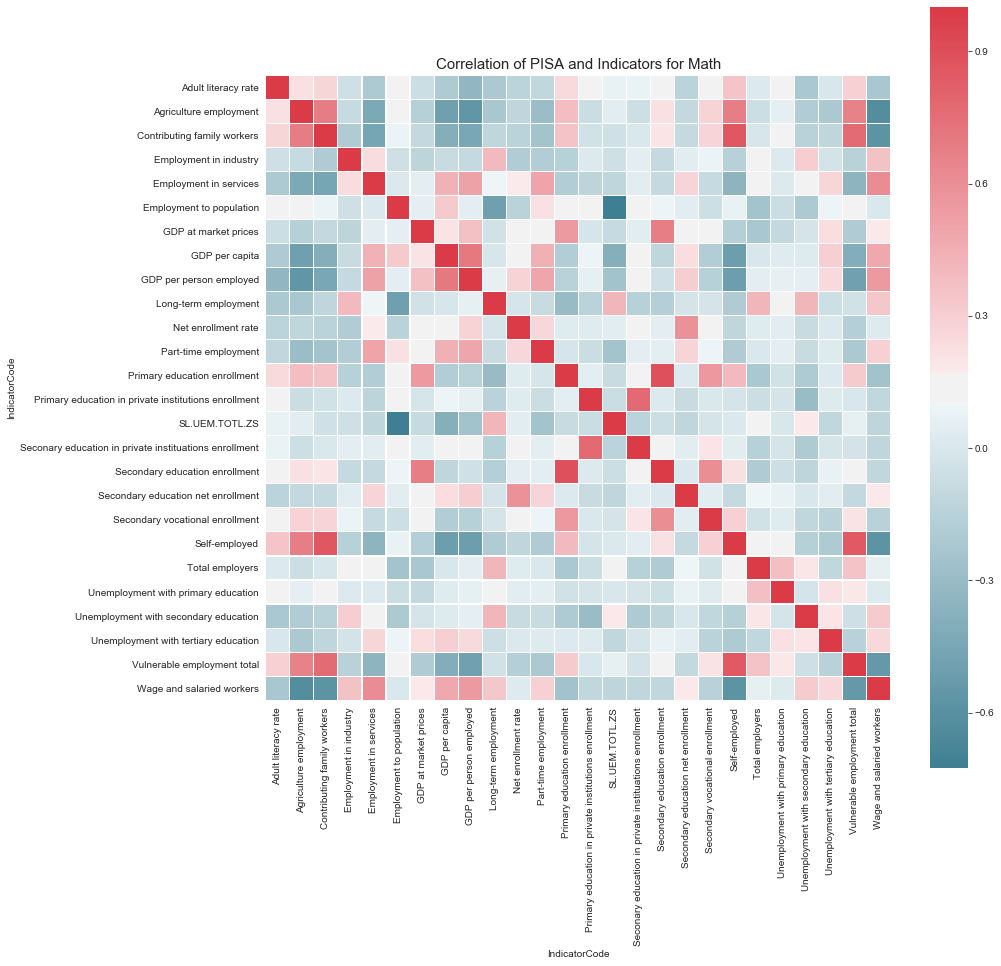

In [48]:
corr = main_pivot.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.heatmap(corr, cbar = True,  square = True, annot=False, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of PISA and Indicators for Math', y=1.05, size=15)

Text(0.5, 1.05, 'Correlation of PISA and Indicators for Math')

<Figure size 1008x1008 with 0 Axes>

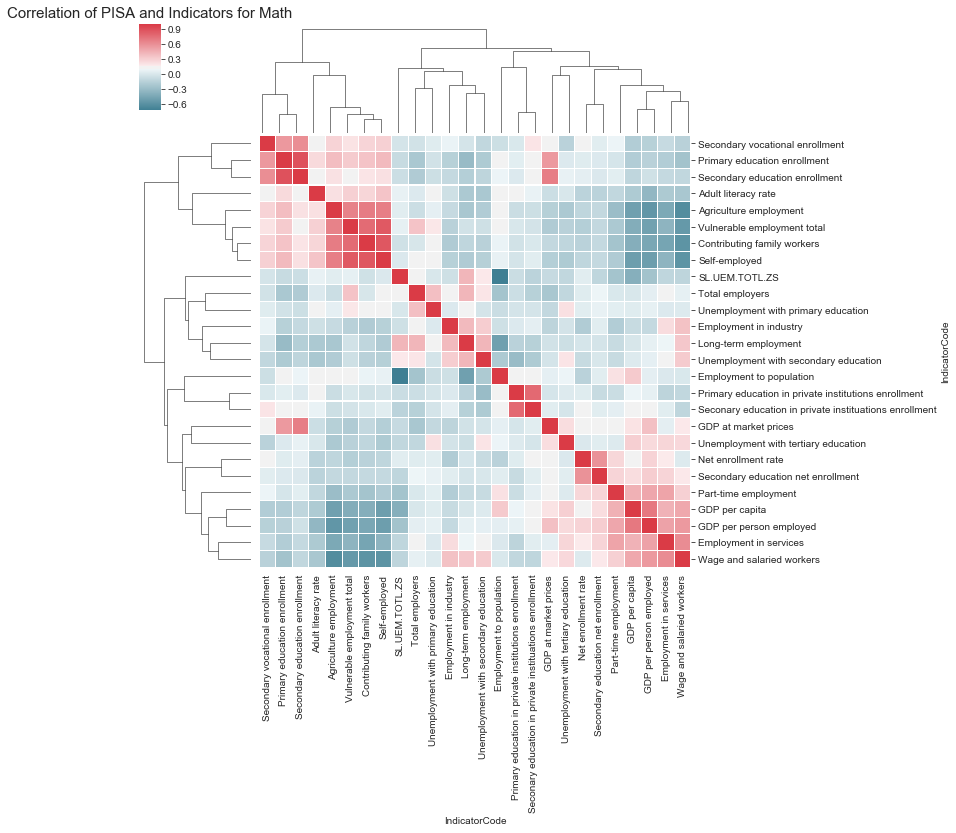

In [49]:
corr = main_pivot.iloc[:,1:-1].corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(14,14))
sns.clustermap(corr, cbar = True,  square = True, annot=False, fmt= '.2f',annot_kws={'size': 12},
            cmap = colormap, linewidths=0.1, linecolor='white')
plt.title('Correlation of PISA and Indicators for Math', y=1.05, size=15)

In [50]:
corr.iloc[0:33,0:33]

IndicatorCode,Adult literacy rate,Agriculture employment,Contributing family workers,Employment in industry,Employment in services,Employment to population,GDP at market prices,GDP per capita,GDP per person employed,Long-term employment,...,Secondary education enrollment,Secondary education net enrollment,Secondary vocational enrollment,Self-employed,Total employers,Unemployment with primary education,Unemployment with secondary education,Unemployment with tertiary education,Vulnerable employment total,Wage and salaried workers
IndicatorCode,,,,,,,,,,,,,,,,,,,,,
Adult literacy rate,1.000,0.221,0.271,-0.046,-0.203,0.104,-0.061,-0.198,-0.335,-0.209,...,0.168,-0.139,0.154,0.348,0.016,0.130,-0.218,-0.001,0.297,-0.222
Agriculture employment,0.221,1.000,0.687,-0.089,-0.434,0.107,-0.163,-0.494,-0.560,-0.221,...,0.213,-0.104,0.285,0.683,-0.064,0.056,-0.181,-0.211,0.657,-0.626
Contributing family workers,0.271,0.687,1.000,-0.187,-0.463,0.084,-0.102,-0.394,-0.447,-0.118,...,0.203,-0.099,0.273,0.859,-0.005,0.167,-0.148,-0.116,0.769,-0.581
Employment in industry,-0.046,-0.089,-0.187,1.000,0.241,-0.046,-0.128,-0.085,-0.095,0.393,...,-0.098,0.040,0.085,-0.154,0.140,0.021,0.308,-0.026,-0.147,0.364
Employment in services,-0.203,-0.434,-0.463,0.241,1.000,0.014,0.051,0.439,0.508,0.101,...,-0.093,0.273,-0.088,-0.355,0.155,0.018,0.139,0.269,-0.349,0.612
Employment to population,0.104,0.107,0.084,-0.046,0.014,1.000,0.062,0.319,0.050,-0.497,...,0.095,0.040,-0.057,0.071,-0.246,-0.066,-0.202,0.094,0.125,0.007
GDP at market prices,-0.061,-0.163,-0.102,-0.128,0.051,0.062,1.000,0.208,0.372,-0.035,...,0.680,0.121,0.123,-0.168,-0.225,-0.100,-0.025,0.233,-0.190,0.178
GDP per capita,-0.198,-0.494,-0.394,-0.085,0.439,0.319,0.208,1.000,0.709,-0.010,...,-0.114,0.236,-0.174,-0.505,0.001,0.034,0.028,0.304,-0.398,0.482
GDP per person employed,-0.335,-0.560,-0.447,-0.095,0.508,0.050,0.372,0.709,1.000,0.069,...,-0.043,0.308,-0.158,-0.508,0.055,0.066,0.058,0.249,-0.490,0.549


We have indicator codes that don't really mean a lot to someone who isn't used to the data.  Let's fix that by renaming our indicator codes to something that makes more sense.

In [51]:
rf_education_clean.IndicatorCode.unique()

array(['Adjusted primary education net enrollment rate',
       'Primary education enrollment', 'Secondary education enrollment',
       'Secondary vocational enrollment', 'Net enrollment rate',
       'Secondary education net enrollment', 'Adult literacy rate',
       'Primary education in private institutions enrollment',
       'Seconary education in private instituations enrollment',
       'Agriculture employment', 'Employment in industry',
       'Employment in services', 'Employment to population',
       'GDP per person employed', 'SL.UEM.TOTL.ZS',
       'Contributing family workers', 'Total employers',
       'Long-term employment', 'Self-employed',
       'Youth not in education, employment or training',
       'Unemployment with primary education',
       'Unemployment with secondary education',
       'Unemployment with tertiary education',
       'Vulnerable employment total', 'Wage and salaried workers',
       'Part-time employment', 'GDP at market prices', 'GDP per cap

In [52]:
pisa_math = pd.pivot_table(data = rf_education_clean, index=['Country','Year'],values='PISA Score Average', fill_value = 0,aggfunc=np.mean)
pisa_math

PISA Score Average
Country                                            Year                    
Albania                                            2000             349.000
                                                   2009             384.333
                                                   2012             395.000
Australia                                          2000             528.000
                                                   2003             524.500
                                                   2006             520.000
                                                   2009             518.667
                                                   2012             512.333
Austria                                            2000             492.000
                                                   2003             498.500
                                                   2006             502.000
                                                   2009             486.667
                                                   2012             500.667
Belgium                                            2000             507.000
                                                   2003             518.000
                                                   2006             510.333
                                                   2009             509.333
                                                   2012             509.667
Brazil                                             2000             396.000
                                                   2003             379.500
                                                   2006             384.333
                                                   2009             401.000
                                                   2012             399.333
Bulgaria                                           2000             430.000
                                                   2006             416.333
                                                   2009             432.000
                                                   2012             440.333
Canada                                             2000             534.000
                                                   2003             530.000
                                                   2006             529.333
...                                                                     ...
Thailand                                           2000             431.000
                                                   2003             418.500
                                                   2006             418.333
                                                   2009             421.667
                                                   2012             437.333
Trinidad and Tobago                                2009             413.333
Tunisia                                            2003             367.000
                                                   2006             377.000
                                                   2009             392.000
                                                   2012             396.667
Turkey                                             2003             432.000
                                                   2006             431.667
                                                   2009             454.333
                                                   2012             462.000
United Arab Emirates                               2012             441.333
United Kingdom of Great Britain and Northern Ir... 2000             523.000
                                                   2003             507.500
                                                   2006             501.667
                                                   2009             500.000
                                                   2012             502.333
United States of America     

### Random Forest

In [53]:
from sklearn.ensemble import RandomForestRegressor

df1 = rf_education_clean
y = pisa_math
X = main_pivot
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20)

radm = RandomForestRegressor()
radm.fit(Xtrain, ytrain)

reg = radm
indices = np.argsort(radm.feature_importances_)[::-1]

print('Feature ranking:')

for f in range(len(indices)):
    print('%d. feature %d %s (%f)' % (f+1 , 
                                      indices[f], 
                                      X.columns[indices[f]], 
                                      radm.feature_importances_[indices[f]]))

Feature ranking:
1. feature 9 GDP per person employed (0.552092)
2. feature 23 Unemployment with secondary education (0.136333)
3. feature 2 Agriculture employment (0.046579)
4. feature 6 Employment to population (0.034718)
5. feature 14 Primary education in private institutions enrollment (0.034166)
6. feature 22 Unemployment with primary education (0.023571)
7. feature 4 Employment in industry (0.019261)
8. feature 8 GDP per capita (0.017094)
9. feature 25 Vulnerable employment total (0.014375)
10. feature 12 Part-time employment (0.013819)
11. feature 26 Wage and salaried workers (0.011360)
12. feature 15 SL.UEM.TOTL.ZS (0.010797)
13. feature 19 Secondary vocational enrollment (0.009265)
14. feature 10 Long-term employment (0.008856)
15. feature 21 Total employers (0.008150)
16. feature 16 Seconary education in private instituations enrollment (0.007691)
17. feature 5 Employment in services (0.006624)
18. feature 13 Primary education enrollment (0.006456)
19. feature 3 Contributing 

In [54]:
radm.score(Xtrain,ytrain)

0.9490986741120025

In [55]:
radm.score(Xtest,ytest)

0.6748546145008679

### Linear Regression

In [56]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

#training
mlregr=linear_model.LinearRegression()
mlregr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
mlregr.coef_

array([[-5.74355500e-01, -1.34604175e-01,  8.49021474e-01,
         1.16111571e+00,  4.36389220e-01, -9.20170498e-02,
         1.37692871e+00,  1.20903287e-12, -3.92979343e-04,
         2.23211569e-03,  2.29274968e-01,  6.88098557e-01,
         2.98924494e-01, -2.34538609e-07, -1.46262163e+00,
         7.83951840e-01,  1.03640359e+00, -2.10806017e-06,
        -1.38793581e-01,  5.00096298e-06, -6.17256109e-01,
         1.82505858e+00, -3.07970337e-01,  5.63323904e-02,
        -1.63382177e-01, -6.09391806e-01,  3.63965022e-01,
         4.61483746e-01]])

In [58]:
mlregr.score(Xtest,ytest) 

0.5927880040735438

In [59]:
#scatterplot of predicted and actuals will be nice here
#the mlregr doesn't look terrible because it is between 0 and 1, but hard because we are looking at whole countries - .24 is not a great score
#if R2 values are very low, can look at the way we did it for the epicurious drill (look at my histogram) - if I changed this to classifier, then we have to change the model

In [74]:
Xtrain.shape

(184, 28)

In [75]:
mlregr=linear_model.LinearRegression()
mlregr.fit(Xtrain,ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Support Vector Regression

In [62]:
rf_education_clean.head()

,Country,Region,Sub Region,Year,IndicatorCodeValue,IndicatorCode,PISA Score Average
6852,Albania,Europe,Southern Europe,2000,93.602,Adjusted primary education net enrollment rate,349.000
7022,Albania,Europe,Southern Europe,2000,283249.000,Primary education enrollment,349.000
7023,Albania,Europe,Southern Europe,2000,365664.000,Secondary education enrollment,349.000
7025,Albania,Europe,Southern Europe,2000,14501.000,Secondary vocational enrollment,349.000
7368,Albania,Europe,Southern Europe,2000,93.602,Net enrollment rate,349.000


In [63]:
rf_education_clean.columns

Index(['Country', 'Region', 'Sub Region', 'Year', 'IndicatorCodeValue',
       'IndicatorCode', 'PISA Score Average'],
      dtype='object')

In [64]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(Xtrain,ytrain)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

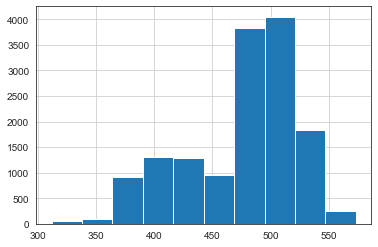

In [65]:
rf_education_clean['PISA Score Average'].hist()
#can do a scatterplot, histogram of residuals - can compare actual data against what model is predicting - look at the histogram
#below, kind of showing the same issue as the recipe drill.

In [66]:
svr.score(Xtest,ytest)

-0.1510558782834421

### Lasso Regression

In [67]:
lass = linear_model.Lasso(alpha=.35)#lasso regression loop to show alpha differences in notebook
#can pick the very best alpha to get the best score - can create a loop around the alpha to do (alpha = 1, alpha = .05)
lassfit = lass.fit(Xtrain, ytrain)
print('R² for the model with few features:')
print(lass.score(Xtrain, ytrain))
#also print out the score for the test set - that is what I should be validating against.  Training set helps to fit model
print(lass.score(Xtest, ytest))
origparams = np.append(lassfit.coef_, lassfit.intercept_)
print('\nParameter estimates for the model with few features:')
print(origparams)

R² for the model with few features:
0.7681729191796565
0.6069414496465225

Parameter estimates for the model with few features:
[-2.81140697e-01 -1.33571524e-01  7.92374092e-01  1.06676685e+00
  4.41768339e-01 -7.06697732e-02  1.31627174e+00  1.15263663e-12
 -3.90040111e-04  2.26336733e-03  2.28921500e-01  3.90947901e-01
  2.71966906e-01 -3.02657752e-07 -1.41572841e+00  6.96089481e-01
  9.83930997e-01 -2.03967397e-06 -1.37668620e-01  5.29910797e-06
 -5.76970558e-01  1.37658859e+00 -2.89734871e-01  5.89366765e-02
 -1.91385749e-01 -5.48899538e-01  3.60462779e-01  4.43988675e-01
  3.00346587e+02]


The R2 for our training set looks prety good, but our R2 for the test set is not as good.  This is indicative of overfitting.  Assumption is that there are a lot of features that are correlated to each other.



In [68]:
#Note - the fact that we have such a big discrepency means that there is probably still some overfitting
#No longer overfitting - we got rid of a lot of redundant features (Male and Female taken out)

### Ridge Regression
#### Use Ridge Regression and Lasso Regression - instead of the Ridge Logistic Regression.  Ridge and Lasso regression will select features.

In [69]:
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.50)
#dont do this again as we have already done this in beginning

In [70]:
ytest.values.flatten()

array([462.        , 492.33333333, 518.66666667, 416.33333333,
       492.        , 494.        , 510.33333333, 486.66666667,
       517.33333333, 326.33333333, 481.33333333, 527.        ,
       392.        , 445.        , 483.        , 417.33333333,
       522.        , 396.        , 513.66666667, 482.        ,
       503.        , 502.33333333, 452.        , 534.        ,
       430.        , 501.66666667, 481.66666667, 454.33333333,
       470.        , 479.        , 498.66666667, 349.        ,
       497.        , 413.33333333, 500.33333333, 503.5       ,
       481.5       , 472.        , 516.        , 401.        ,
       458.5       , 367.        , 428.        , 528.        ,
       495.66666667, 485.        , 509.66666667])

In [71]:
ridge = linear_model.Ridge()
fit = ridge.fit(Xtrain, ytrain)

print('Coefficients')
print(pd.DataFrame(fit.coef_, columns=Xtest.columns))
print('\nIntercept:{}'.format(fit.intercept_))
    
print('\n Percentage accuracy training set')
print(ridge.score(Xtrain, ytrain))

print('\n Percentage accuracy testing set')
print(ridge.score(Xtest, ytest))

pred_y_sklearn = ridge.predict(Xtest)
print('\n Indicator Code and PISA Scores')
print(pd.crosstab(pred_y_sklearn.flatten(), ytest.values.flatten()))

Coefficients
IndicatorCode  Adjusted primary education net enrollment rate  \
0                                                      -0.573   

IndicatorCode  Adult literacy rate  Agriculture employment  \
0                           -0.135                   0.848   

IndicatorCode  Contributing family workers  Employment in industry  \
0                                    1.158                   0.436   

IndicatorCode  Employment in services  Employment to population  \
0                              -0.092                     1.376   

IndicatorCode  GDP at market prices  GDP per capita  GDP per person employed  \
0                             0.000          -0.000                    0.002   

IndicatorCode  ...  Secondary education net enrollment  \
0              ...                              -0.139   

IndicatorCode  Secondary vocational enrollment  Self-employed  \
0                                        0.000         -0.616   

IndicatorCode  Total employers  Unemployment w

In [72]:
#to finish show how you would pick best model and decide on parameters.  ex if random forest is best and we use feature 

In [73]:
#After choose models and figure out the best, then what is the "so what" - how could it be used, how would it be helpful, etc (could it help countries improve PISA scores - would educators look at it, parents, etc)
#expats?